# Imports

In [1]:
import sys
import os

parent_module_path = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))


sys.path.append(parent_module_path)
parent_module_path

'/workspaces/line-detection'

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Debug: Check sys.path
print("Current sys.path:")
for path in sys.path:
    print(f"  {path}")
    
print(f"\nCurrent working directory: {os.getcwd()}")
print(f"Parent module path: {parent_module_path}")

# Check if src directory exists
import os
src_path = os.path.join(parent_module_path, 'src')
print(f"Does src directory exist? {os.path.exists(src_path)}")
if os.path.exists(src_path):
    print(f"Contents of src: {os.listdir(src_path)}")

Current sys.path:
  /usr/local/lib/python311.zip
  /usr/local/lib/python3.11
  /usr/local/lib/python3.11/lib-dynload
  
  /usr/local/lib/python3.11/site-packages
  /workspaces/line-detection

Current working directory: /workspaces/line-detection/src/notebooks
Parent module path: /workspaces/line-detection
Does src directory exist? True
Contents of src: ['app', '__init__.py', '__pycache__', 'project_utils', 'notebooks']


(np.float64(-0.5), np.float64(395.5), np.float64(282.5), np.float64(-0.5))

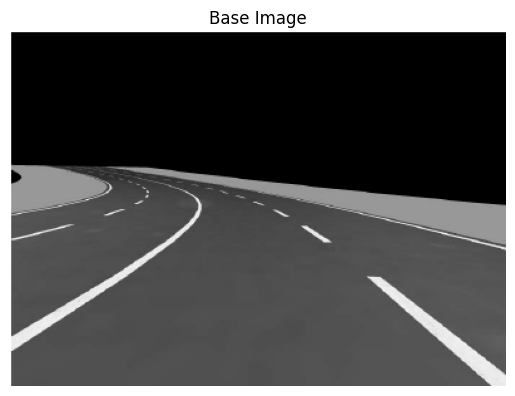

In [4]:
image_path: str = "../../images/lane-detection-test-image.png"
image = cv2.imread(image_path)
assert image is not None, f"Image not found at path: {image_path}"
plt.imshow(image)
plt.title("Base Image")
plt.axis("off")

# Run canny detection

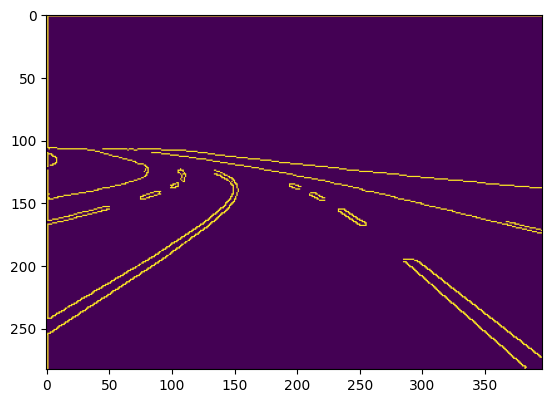

In [ ]:
from src.project_utils.edge_detection import create_canny_edge_detection_img

assert image is not None, f"Image not found at path: {image_path}"
canny_image = create_canny_edge_detection_img(image)
plt.imshow(canny_image)

# Get Hough Lines

In [6]:
from src.project_utils.hough_transform import get_hough_lines

In [7]:
# Get lines using the default parameters
lines = get_hough_lines(canny_image) 
lines

array([[[  1,   1, 395,   1]],

       [[  1, 242,   1,   2]],

       [[ 86, 107, 389, 138]],

       [[  2, 242, 113, 175]],

       [[  0, 255, 107, 185]],

       [[222, 132, 394, 174]]], dtype=int32)

In [8]:
lines.shape

(6, 1, 4)

In [9]:
copy_image = np.copy(image)
for line in lines:
    for x1, y1, x2, y2 in line:
        cv2.line(copy_image, (x1, y1), (x2, y2), (255, 0, 0), 10)

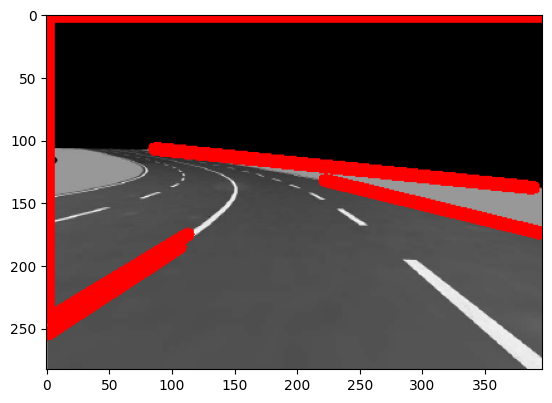

In [10]:
plt.imshow(copy_image)

# Average the slope intercept of the lines

In [11]:
left_lines, right_lines = [], []

In [12]:
for line in lines:
    x1, y1, x2, y2 = line.reshape(4)
    parameters = np.polyfit((x1, x2), (y1, y2), 1)
    print(parameters)
    slope = parameters[0]
    intercept = parameters[1]
    # Lines on the left always have a negative slope
    if slope < 0:
        left_lines.append((slope, intercept))
    else:
        right_lines.append((slope, intercept))

[8.43204658e-19 1.00000000e+00]
[61. 61.]
[ 0.10231023 98.20132013]
[ -0.6036036  243.20720721]
[ -0.65420561 255.        ]
[ 0.24418605 77.79069767]


/tmp/ipykernel_4563/2632437443.py:3: RankWarning: Polyfit may be poorly conditioned
  parameters = np.polyfit((x1, x2), (y1, y2), 1)


In [13]:
left_lines

[(np.float64(-0.6036036036036027), np.float64(243.2072072072072)),
 (np.float64(-0.6542056074766358), np.float64(254.99999999999991))]

In [14]:
right_lines

[(np.float64(8.432046583331352e-19), np.float64(0.9999999999999996)),
 (np.float64(60.99999999999999), np.float64(60.999999999999986)),
 (np.float64(0.10231023102310226), np.float64(98.20132013201325)),
 (np.float64(0.24418604651162784), np.float64(77.79069767441861))]

# Get the mean average of the lines

In [15]:
left_fit_average = np.average(left_lines, axis=0)
right_lines_average = np.average(right_lines, axis=0)

In [16]:
left_fit_average, right_lines_average

(array([ -0.62890461, 249.1036036 ]), array([15.33662407, 59.49800445]))

# Get start Coordinates

In [17]:
def make_coordinates(image: np.ndarray, line_parameters: np.ndarray) -> np.ndarray:
    slope, intercept = line_parameters
    y1 = image.shape[0]
    ratio_up_the_screen = 3 / 5
    y2 = int(y1 * (ratio_up_the_screen))
    x1 = int((y1 - intercept) / slope)
    x2 = int((y2 - intercept) / slope)
    return np.array([x1, y1, x2, y2])

In [18]:
right_line = make_coordinates(image, right_lines_average)
left_line = make_coordinates(image, left_fit_average)

In [19]:
right_line

array([ 14, 283,   7, 169])

In [20]:
left_line

array([-53, 283, 127, 169])

In [ ]:
x1, y1, x2, y2 = right_line
cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2) # type: ignore

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [ 80,  80,  80],
        [ 80,  80,  80],
        ...,
        [231, 231, 231],
        [237, 237, 237],
        [241, 241, 241]],

       [[255, 255, 255],
        [ 80,  80,  80],
        [ 80,  80,  80],
        ...,
        [234, 234, 234],
        [236, 236, 236],
        [237, 237, 237]],

       [[255, 255, 255],
        [ 80,  80,  80],
        [ 80,  80,  80],
        ...,
        [237, 237, 237],
        [236, 236, 236],
        [235, 235, 235]]

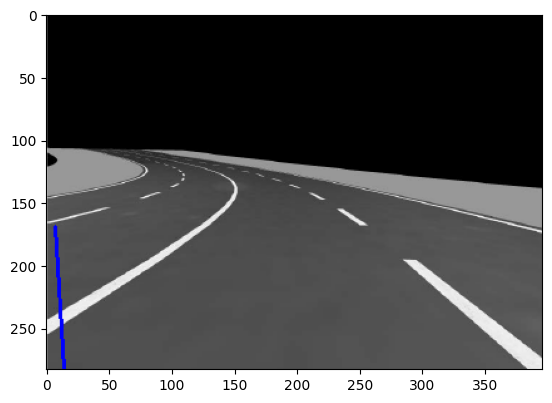

In [22]:
plt.imshow(image)

In [23]:
x1, y1, x2, y2 = left_line
cv2.line(image, (x1, y1), (x2, y2), (0, 0, 255), 2)

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[255, 255, 255],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[255, 255, 255],
        [ 80,  80,  80],
        [ 80,  80,  80],
        ...,
        [231, 231, 231],
        [237, 237, 237],
        [241, 241, 241]],

       [[255, 255, 255],
        [ 80,  80,  80],
        [ 80,  80,  80],
        ...,
        [234, 234, 234],
        [236, 236, 236],
        [237, 237, 237]],

       [[255, 255, 255],
        [ 80,  80,  80],
        [ 80,  80,  80],
        ...,
        [237, 237, 237],
        [236, 236, 236],
        [235, 235, 235]]

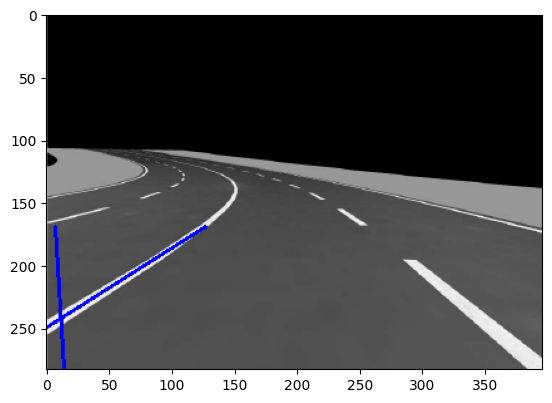

In [24]:


plt.imshow(image)